In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
results_path = '../results/'

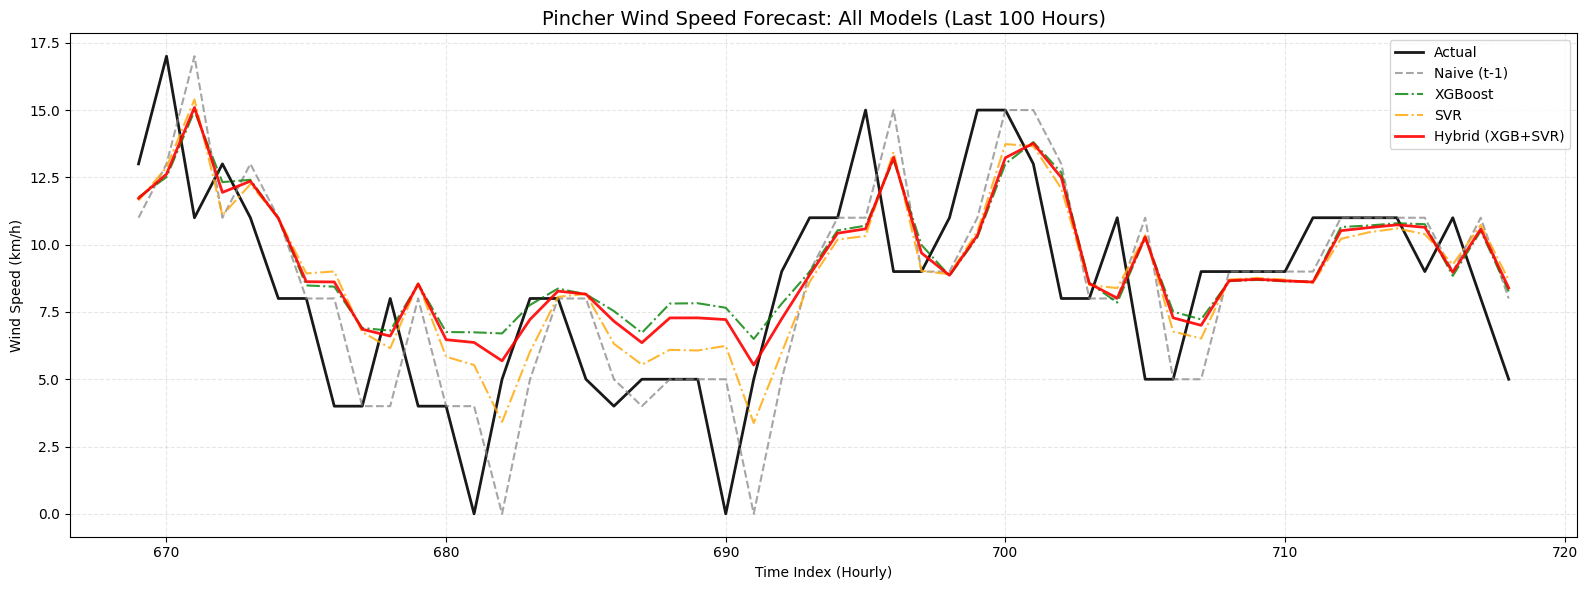

In [4]:

# 1. Load data
y_test = np.load(results_path + 'pincher_y_test.npy')          # shape: (720,) assuming -720 test split
xgb_pred = np.load(results_path + 'pincher_xgb_preds_1.npy')
svr_pred = np.load(results_path + 'pincher_svr_preds.npy')

# Align with test set (drop first if needed; should already match)
assert len(y_test) == len(xgb_pred) == len(svr_pred)

obs = y_test[1:]                 # naive uses t-1, so true starts at index 1
naive_pred = y_test[:-1]         # shift(1) → t-1 as prediction for t

# Truncate all to same length (naive loses 1 point)
xgb_pred_aligned = xgb_pred[1:]
svr_pred_aligned = svr_pred[1:]

# 2. Compute optimal blend (from your result: weight_xgb = 0.69)
best_weight = 0.69
blend_pred = best_weight * xgb_pred_aligned + (1 - best_weight) * svr_pred_aligned

# 3. Plot last 100 points
limit = 50
idx = np.arange(len(obs))[-limit:]

plt.figure(figsize=(16, 6))
plt.plot(idx, obs[-limit:], label='Actual', color='black', linewidth=2, alpha=0.9)
plt.plot(idx, naive_pred[-limit:], label='Naive (t-1)', color='gray', linestyle='--', alpha=0.7)
plt.plot(idx, xgb_pred_aligned[-limit:], label='XGBoost', color='green', linestyle='-.', alpha=0.8)
plt.plot(idx, svr_pred_aligned[-limit:], label='SVR', color='orange', linestyle='-.', alpha=0.8)
plt.plot(idx, blend_pred[-limit:], label='Hybrid (XGB+SVR)', color='red', linewidth=2, alpha=0.9)

plt.title('Pincher Wind Speed Forecast: All Models (Last 100 Hours)', fontsize=14)
plt.ylabel('Wind Speed (km/h)')
plt.xlabel('Time Index (Hourly)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Load and align data ---
y_test = np.load(results_path + 'pincher_y_test.npy')
xgb_pred = np.load(results_path + 'pincher_xgb_preds_1.npy')
svr_pred = np.load(results_path + 'pincher_svr_preds.npy')

# Align for naive baseline (predict t using t-1 → drop first true point)
obs = y_test[1:]                 # actuals from t=1 to end
naive_pred = y_test[:-1]         # predictions = previous hour
xgb_pred_aligned = xgb_pred[1:]
svr_pred_aligned = svr_pred[1:]

# Fixed-weight hybrid (from your Bayesian blend)
best_weight = 0.69
blend_pred = best_weight * xgb_pred_aligned + (1 - best_weight) * svr_pred_aligned

# --- 2. Define models ---
models = {
    'Naive (t-1)': naive_pred,
    'XGBoost': xgb_pred_aligned,
    'SVR': svr_pred_aligned,
    'Hybrid (XGB+SVR)': blend_pred
}

# --- 3. Compute metrics (including NRMSE) ---
# NRMSE = RMSE / (max(obs) - min(obs))  → normalized by observed range
obs_range = obs.max() - obs.min()

results = []
for name, pred in models.items():
    mae = mean_absolute_error(obs, pred)
    rmse = np.sqrt(mean_squared_error(obs, pred))
    nrmse = rmse / obs_range if obs_range > 0 else np.nan
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'NRMSE': nrmse})

# --- 4. Create and display table ---
df_metrics = pd.DataFrame(results).set_index('Model')
df_metrics = df_metrics[['MAE', 'RMSE', 'NRMSE']]  # enforce column order

print("\nPincher Forecast Performance (Test Set)\n")
print(df_metrics.round(5))

# Optional: Save to CSV
df_metrics.to_csv(results_path + 'pincher_model_comparison_with_NRMSE.csv')


Pincher Forecast Performance (Test Set)

                      MAE     RMSE    NRMSE
Model                                      
Naive (t-1)       6.76773  9.77835  0.13581
XGBoost           6.27448  8.77723  0.12191
SVR               6.42267  8.99497  0.12493
Hybrid (XGB+SVR)  6.28305  8.78350  0.12199
